In [1]:
import rebound

In [2]:
sim = rebound.Simulation("/home/alchzh/cassum-2022-project-21/workspace/sim/simon_simulations_20220613/iopf_sim_DRAG_1.0__ALPHA_-2_BETA_None_0/rebound_archive.bin")

/home/alchzh/cassum-2022-project-21/workspace/src/rebound/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


In [3]:
from numpy import sqrt
from itertools import count

for i in count():
    sim = rebound.Simulation("/home/alchzh/cassum-2022-project-21/workspace/sim/simon_simulations_20220613/iopf_sim_DRAG_1.0__ALPHA_-2_BETA_None_0/rebound_archive.bin", i)
    p = sim.particles[1]
    print(p.a)

/home/alchzh/cassum-2022-project-21/workspace/src/rebound/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


0.23600328174987403
0.23598427014111334
0.23597036755109194
0.23596139637376037
0.23595732289630628
0.23595944642754452
0.23596731089163994
0.23597994118748572
0.23602015132165152
0.23607708237060612
0.23613281030604344
0.23607003783306982
0.23530414893446305
0.23524734122434843
0.2353736727453296
0.23537301494278132
0.23520881318555173
0.23613134493124627


RuntimeError: Index out of range.

/home/alchzh/cassum-2022-project-21/workspace/src/rebound/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


t=1.000000, p1: x=-0.148, y=-0.206, r=0.254 AU, vx_gas=10.129, p.vx=10.649, vy_gas=-7.263, p.vy=-5.534, v_gas=12.464, v_rel=1.806, F_d=1.019e-10, F_G=7.294e-04, P_d=2.274632e-10
t=1.000000, p2: x=0.135, y=0.140, r=0.194 AU, vx_gas=-10.264, p.vx=-9.550, vy_gas=9.913, p.vy=12.132, v_gas=14.270, v_rel=2.331, F_d=2.095e-10, F_G=1.897e-03, P_d=-1.807047e-09
t=2.000000, p1: x=-0.251, y=0.100, r=0.270 AU, vx_gas=-4.487, p.vx=-4.869, vy_gas=-11.213, p.vy=-10.063, v_gas=12.077, v_rel=1.211, F_d=4.194e-11, F_G=6.429e-04, P_d=3.361659e-10
t=2.000000, p2: x=0.023, y=-0.218, r=0.219 AU, vx_gas=13.371, p.vx=13.201, vy_gas=1.407, p.vy=4.306, v_gas=13.445, v_rel=2.904, F_d=3.741e-10, F_G=1.495e-03, P_d=-1.318732e-09
t=3.000000, p1: x=0.084, y=0.199, r=0.216 AU, vx_gas=-12.459, p.vx=-12.073, vy_gas=5.257, p.vy=7.194, v_gas=13.523, v_rel=1.975, F_d=1.287e-10, F_G=1.002e-03, P_d=-6.038842e-10
t=3.000000, p2: x=-0.264, y=-0.099, r=0.282 AU, vx_gas=4.128, p.vx=4.640, vy_gas=-11.071, p.vy=-9.511, v_gas=11.8

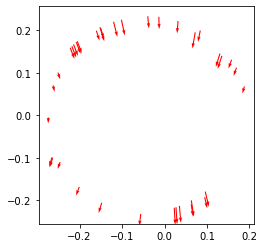

In [4]:
import rebound
import numpy as np
from amuse.units import units
from scipy.interpolate import interp1d
from itertools import count 
from numpy import sqrt

velocity_file = "../disk/velocity.txt"
density_file = "../disk/midplane_density_2.txt"

C_d = 1.0
G = 4 * np.pi * np.pi

r, vt_gas_cms, vr_gas_cms = np.loadtxt(velocity_file).T
vt_gas = (vt_gas_cms | (units.cm / units.s)).value_in(units.AU / units.yr)
vr_gas = (vr_gas_cms | (units.cm / units.s)).value_in(units.AU / units.yr)

_, rho_0_cms = np.loadtxt(density_file).T
rho_0 = (rho_0_cms | (units.g / units.cm**3)).value_in(units.MSun / (units.AU**3))

interpf = interp1d(r, np.stack([vt_gas, vr_gas, rho_0]))

def mag_dir_2d(x, y):
    r = np.sqrt(x*x + y*y)
    return r, x / r, y / r
    

xl_p = []
yl_p = []
vxl_p = []
vyl_p = []
vxl_gas = []
vyl_gas = []

for i in count():
    try:
        sim = rebound.Simulation("/home/alchzh/cassum-2022-project-21/workspace/sim/simon_simulations_20220613/iopf_sim_DRAG_1.0__ALPHA_-2_BETA_None_0/rebound_archive.bin", i)
    except RuntimeError:
        break

    sun = sim.particles[0]
    # print(f"Sun: v_x={sun.vx}, v_y={sun.vy}")
    for i, p in enumerate(sim.particles[1:]):
        x = p.x
        y = p.y
        # z = p.z

        _r, ux, uy = mag_dir_2d(x, y)

        _vt_gas, _vr_gas, _rho_0 = interpf(_r)

        vx_gas = ux * _vr_gas - uy * _vt_gas
        vy_gas = uy * _vr_gas + ux * _vt_gas

        vx_rel = vx_gas - p.vx
        vy_rel = vy_gas - p.vy

        v_rel, ux_rel, uy_rel = mag_dir_2d(vx_rel, vy_rel)

        A = np.pi * p.r * p.r
        F_d = 0.5 * _rho_0 * v_rel * v_rel * C_d * A

        # p.ax += F_d * ux_rel
        # p.ay += F_d * uy_rel

        print(f"t={sim.t:f}, p{i+1}: {x=:.3f}, {y=:.3f}, r={_r:.3f} AU, {vx_gas=:.3f}, {p.vx=:.3f}, {vy_gas=:.3f}, {p.vy=:.3f}, v_gas={sqrt(vx_gas*vx_gas + vy_gas*vy_gas):.3f}, v_rel={v_rel:.3f}, F_d={F_d:.3e}, F_G={G * p.m * sun.m / (_r * _r):.3e}, P_d={F_d * ux_rel * p.vx + F_d * uy_rel * p.vy:3e}")        
        
        xl_p.append(p.x)
        yl_p.append(p.y)
        vxl_p.append(p.vx)
        vyl_p.append(p.vy)
        vxl_gas.append(vx_gas)
        vyl_gas.append(vy_gas)

import matplotlib.pyplot as plt

# plt.quiver(xl_p, yl_p, vxl_p, vyl_p, color="green", width=0.005)
# plt.quiver(xl_p, yl_p, vxl_gas, vyl_gas, color="blue", width=0.005)

# plt.quiver(xl_p, yl_p, vxl_p, vyl_p, color="green", width=0.005)
plt.quiver(xl_p, yl_p, np.array(vxl_gas) - np.array(vxl_p), np.array(vyl_gas) - np.array(vyl_p), color="red", width=0.005)
plt.gca().set_aspect('equal')
plt.savefig("relative_velocity.png", facecolor="white")


In [7]:
%load_ext autoreload
%autoreload 1

import rebound
import ctypes
%aimport c_forces
import numpy as np
from amuse.units import units

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
velocity_file = "../disk/velocity.txt"
density_file = "../disk/midplane_density_2.txt"

r, vt_gas_cms, vr_gas_cms = np.loadtxt(velocity_file).T
vt_gas = (vt_gas_cms | (units.cm / units.s)).value_in(units.AU / units.yr)
vr_gas = (vr_gas_cms | (units.cm / units.s)).value_in(units.AU / units.yr)

_, rho_0_cms = np.loadtxt(density_file).T
rho_0 = (rho_0_cms | (units.g / units.cm**3)).value_in(units.MSun / (units.AU**3))

In [9]:
c_forces.set_profiles(r, [vt_gas, vr_gas], rho_0)

In [10]:
sim = rebound.Simulation("/home/alchzh/cassum-2022-project-21/workspace/sim/simon_simulations_20220613/iopf_sim_DRAG_1.0__ALPHA_-2_BETA_None_0/rebound_archive.bin", -1)
print(sim.particles[2].ax)
print(c_forces.IOPF_drag_force(sim.particles[2]))
print(sim.particles[2].ax)

352.93914463653846
nan
352.93914463653846


/home/alchzh/cassum-2022-project-21/workspace/src/rebound/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


In [15]:
print(list(r))

[0.02, 0.02057958, 0.021175960000000001, 0.021789630000000001, 0.022421070000000001, 0.023070819999999999, 0.023739389999999999, 0.024427339999999999, 0.025135230000000001, 0.025863629999999999, 0.02661314, 0.02738436, 0.028177939999999999, 0.028994519999999999, 0.029834759999999998, 0.030699339999999999, 0.031588989999999997, 0.032504409999999997, 0.033446360000000001, 0.034415609999999999, 0.035412949999999999, 0.036439190000000003, 0.037495170000000001, 0.038581749999999998, 0.039699819999999997, 0.040850289999999997, 0.042034099999999998, 0.043252220000000001, 0.044505629999999997, 0.045795370000000002, 0.047122490000000003, 0.048488059999999999, 0.04989321, 0.051339070000000001, 0.05282684, 0.054357719999999998, 0.055932959999999997, 0.057553859999999998, 0.059221719999999999, 0.06093792, 0.06270386, 0.064520969999999997, 0.066390729999999995, 0.068314689999999997, 0.070294389999999998, 0.072331469999999995, 0.074427579999999993, 0.076584429999999995, 0.078803789999999999, 0.08108

In [1]:
import matplotlib.pyplot as plt

In [2]:
scales = ["0.90", "0.95", "0.99", "1.00", "1.01", "1.05", "1.10"]

Finished 0.90
Finished 0.95
Finished 0.99
Finished 1.00
Finished 1.01
Finished 1.05
Finished 1.10


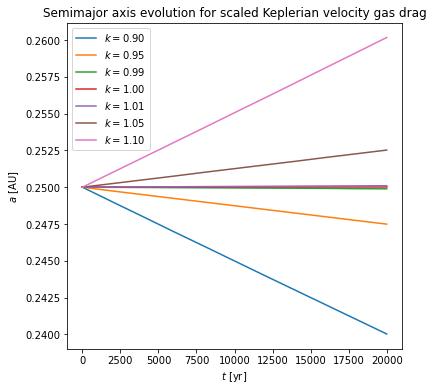

In [56]:
import re

fig, axs = plt.subplots(1, 1, figsize=(6, 6))
for scale in scales:
    with open(f"rebforces/test/output2-{scale}.txt", "r") as f:
        tn = []
        an = []
        Pn = []
        dEn = []
        for l in f.read().split("\n\n"):
            if not l:
                break
            d = re.split(r", |=|\n|\s", l)
            t = float(d[1])
            a = float(d[-5])
            P = float(d[-1])
            dE = float(d[3])
            tn.append(t)
            an.append(a)
            Pn.append(P)
            dEn.append(dE)
            if t > 20000:
                print(f"Finished {scale}")
                break
        axs.plot(tn, an, label=f"$k = {scale}$")

axs.set_title("Semimajor axis evolution for scaled Keplerian velocity gas drag")
axs.set_ylabel("$a$ [AU]")
axs.set_xlabel("$t$ [yr]")
axs.legend()

The total mechanical energy of the orbit is
$$E = K + U = \frac{1}{2}mv^2 - \frac{GMm}{a} = -\frac{GMm}{2a}$$
The non-conservative drag force $F_d$ does work
$$dE = F_d \cdot ds = F_d v dt = F_d \sqrt{\frac{GM}{a}} dt$$
$$\frac{dE}{dt} = F_d \sqrt{\frac{GM}{a}}$$
$$\frac{dE}{da} = \frac{GMm}{2 a^2}$$
$$\frac{da}{dt} = \frac{2 F_d}{m} \sqrt{\frac{a^3}{GM}}$$

Assuming the force is small and $a$ is approximately constant, over half an orbital period
$$h = \pi \sqrt{\frac{a^3}{GM}}$$
$$\Delta a = h \cdot \frac{da}{dt} = \frac{2 \pi F_d a^3}{GMm}$$

We apply a drag force of magnitude
$$F_d = \frac{1}{2} C_d \pi r^2 \rho_{gas} {v_{rel}}^2 $$
The relative velocity depends on $k$ as
$$v_{rel} = (k-1)v_{kep} = (k-1) \sqrt{\frac{G M}{a}}$$
$$F_d(a) = \frac{1}{2} C_d \pi r^2 \rho_{gas} (k-1)^2\frac{G M}{a}$$

In AU/solar mass/sidereal year units:
$$G = 4 \pi^2$$
$$M = 1$$
$$m = 3\times 10^{-6}$$
$$r = 4.26352\times 10^{-5}$$
$$\rho_{gas} = 5\times 10^{-9}\,\mathrm{g\,cm}^{-3}=8.41645\times 10^{-3}$$
$$C_d = 1$$

At $a = 0.25$

$$
\renewcommand{\e}[2]{{#1}\times 10^{{#2}}}

\begin{array}{|c|c|c|}
\hline
k & F_d & \Delta a_{1/2} \\ \hline
0.90 & \e{3.7950}{-11} & \e{3.1457}{-10} \\ \hline
0.95 & \e{9.4875}{-12} & \e{7.8641}{-9} \\ \hline
0.99 & \e{3.7950}{-13} & \e{3.1457}{-10} \\ \hline
1.00 & 0 & 0 \\ \hline
\end{array}
$$


In [3]:
fscales = tuple(map(float, scales))
fscales

(0.9, 0.95, 0.99, 1.0, 1.01, 1.05, 1.1)

In [11]:
from math import pi
G = 4 * pi * pi
M = 1 + 3e-6
m = 3e-6
r = 4.26352e-5
rho = 8.41645e-3
C_d = 1
a = 0.249996250
for k in fscales:
    F_d = 0.5 * C_d * pi * r * r * rho * (k-1)**2 * G * M / a
    a_d = F_d / m
    dA = 2 * pi * F_d * a**3 / (G * M * m)
    print(f"{k:02f} {F_d:.04e}, {dA:.04e}")

0.900000 3.7950e-11, 3.1457e-08
0.950000 9.4875e-12, 7.8641e-09
0.990000 3.7950e-13, 3.1457e-10
1.000000 0.0000e+00, 0.0000e+00
1.010000 3.7950e-13, 3.1457e-10
1.050000 9.4875e-12, 7.8641e-09
1.100000 3.7950e-11, 3.1457e-08
